Here I load multiple multivariate timeseries regression datasets

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change. But blacklist large modules
%load_ext autoreload
%autoreload 2
%aimport -pandas
%aimport -torch
%aimport -numpy
%aimport -matplotlib
%aimport -dask
%aimport -tqdm
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 3.0)
plt.style.use('ggplot')

import holoviews as hv
from holoviews.operation.datashader import datashade, dynspread

In [3]:
import os
from tqdm.auto import tqdm
from pathlib import Path
from torchvision.datasets.utils import download_url, extract_archive, download_and_extract_archive

In [4]:
import sklearn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn_pandas import DataFrameMapper

def normalize_encode_dataframe(df, encoder=OrdinalEncoder):
    """Normalise numeric data, encode categorical data."""
    columns_input_numeric = list(df._get_numeric_data().columns)
    columns_categorical = list(set(df.columns)-set(columns_input_numeric))
    
    transformers= [([n], StandardScaler()) for n in columns_input_numeric] + \
                  [([n], encoder()) for n in columns_categorical]
    scaler = DataFrameMapper(transformers, df_out=True)
    df_norm = scaler.fit_transform(df)
    return df_norm, scaler
    
def timeseries_split(df, test_fraction=0.2):
    """Split timeseries data with test in the future"""
    i = int(len(df)*test_fraction)
    return df.iloc[:i], df.iloc[i:]

In [5]:
from typing import List, Tuple
from seq2seq_time.data.dataset import Seq2SeqDataSet

In [6]:
datasets_root = Path('../data/processed/')

In [7]:
class RegressionForecastData:   
    columns_forecast = None # The input colums which can be included in future (e.g. week or weather forecast)
    columns_target = None # Target columns
    
    def __init__(self, datasets_root):        
        self.datasets_root = datasets_root
        
        # Process data
        self.df = self.download()        
        self.df_norm, self.scaler = self.normalize(self.df)
        self.output_scaler = next(filter(lambda r:r[0][0] in self.columns_target, self.scaler.features))[-1]
        self.df_train, self.df_test = self.split(self.df_norm)
        
        # Check processing
        self.check()
    
    def download(self) -> pd.DataFrame:
        """Implement this method to download data and return raw df"""
        raise NotImplementedError()
        return df
    
    def normalize(self, df) -> Tuple[pd.DataFrame, DataFrameMapper]:
        df_norm, scaler = normalize_encode_dataframe(df)
        return df_norm, scaler
    
    def split(self, df_norm: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        df_train, df_test = timeseries_split(df_norm)
        return df_train, df_test 
    
    def check(self) -> None:
        """Check the resulting dataframe"""
        assert isinstance(self.df.index, pd.DatetimeIndex), 'index must be datetime'
        assert self.df.index.freq is not None, 'df must have freq'        
        assert self.columns_forecast is not None
        assert self.columns_target is not None
        assert ~set(self.columns_target).issubset(set(self.columns_forecast)), 'target columns should not be in forecast'
        assert set(self.columns_forecast).issubset(set(self.df.columns)), 'columns_forecast must be in df'
        assert set(self.columns_target).issubset(set(self.df.columns)), 'columns_target must be in df'
        
    def to_datasets(self, window_past: int, window_future: int, valid:bool=False) -> Tuple[Seq2SeqDataSet, Seq2SeqDataSet]:
        """Convert to torch datasets"""
        ds_train = Seq2SeqDataSet(df_train, window_past=window_past, window_future=window_future, columns_target=self.columns_target, columns_past=self.columns_past)
        ds_test = Seq2SeqDataSet(df_test, window_past=window_past, window_future=window_future, columns_target=self.columns_target, columns_past=self.columns_past)
        return ds_train, ds_test
    
    def __repr__(self):
        return f'<{type(self).__name__} {self.df.shape if (self.df is not None) else None}>'

<GasSensor (303034, 6)>


,CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm)
Time (s),,,,,,
2016-10-16 05:36:55.800,0.0,48.4700,24.6200,247.4926,0.2000,0.6831
2016-10-16 05:36:56.100,0.0,48.4700,24.6200,243.8282,0.1998,0.6649
2016-10-16 05:36:56.400,0.0,48.4700,24.6200,243.0668,0.2000,0.6481
2016-10-16 05:36:56.700,0.0,48.4700,24.6200,242.3030,0.2000,0.6318
2016-10-16 05:36:57.000,0.0,48.4702,24.6206,241.5632,0.2000,0.6178
...,...,...,...,...,...,...
2016-10-17 06:52:04.500,0.0,63.9400,24.6200,0.0000,0.2080,9.9322
2016-10-17 06:52:04.800,0.0,63.9400,24.6200,0.0000,0.2050,31.7887
2016-10-17 06:52:05.100,0.0,63.9400,24.6200,0.0000,0.2040,57.7304


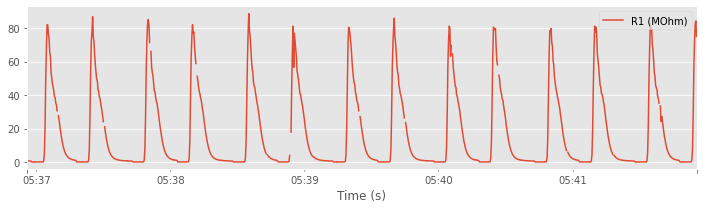

In [8]:
class GasSensor(RegressionForecastData):
    """
    See: http://archive.ics.uci.edu/ml/datasets/Gas+sensor+array+temperature+modulation
    """
    
    columns_target = ['R1 (MOhm)']
    columns_forecast = ['Flow rate (mL/min)', 'Heater voltage (V)']
    
    def download(self):
        url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00487/gas-sensor-array-temperature-modulation.zip'
        
        # download if needed
        extract_path = self.datasets_root/'GasSensor'
        files = sorted(extract_path.glob('*.csv'))
        if len(files)<13:
            print('download_and_extract_archive')
            download_and_extract_archive(url, self.datasets_root, extract_path)
        
        # Load csv's
        files = sorted(extract_path.glob('*.csv'))
        dfs = []
        for f in files:
            now = pd.to_datetime(f.stem, format='%Y%m%d_%H%M%S')
            df = pd.read_csv(f)
            df.index = pd.to_timedelta(df['Time (s)'], unit='s') + now
            dfs.append(df)
        self.df = pd.concat(dfs).dropna(subset=self.columns_target)

        df = df[[ 'CO (ppm)', 'Humidity (%r.h.)', 'Temperature (C)',
               'Flow rate (mL/min)', 'Heater voltage (V)', 'R1 (MOhm)']]
        df = df.resample('0.3S').first()
        
        return df
dataset = GasSensor(datasets_root)
print(dataset)
dataset.df[dataset.columns_target].head(1000).plot()
dataset.df

<MetroInterstateTraffic (52551, 14)>



,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,month,day,week,hour,minute,dayofweek
date_time,,,,,,,,,,,,,,
2012-10-02 09:00:00,True,288.28,0.0,0.0,40.0,Clouds,scattered clouds,5545.0,10,2,40,9,0,1
2012-10-02 10:00:00,True,289.36,0.0,0.0,75.0,Clouds,broken clouds,4516.0,10,2,40,10,0,1
2012-10-02 11:00:00,True,289.58,0.0,0.0,90.0,Clouds,overcast clouds,4767.0,10,2,40,11,0,1
2012-10-02 12:00:00,True,290.13,0.0,0.0,90.0,Clouds,overcast clouds,5026.0,10,2,40,12,0,1
2012-10-02 13:00:00,True,291.14,0.0,0.0,75.0,Clouds,broken clouds,4918.0,10,2,40,13,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,True,283.45,0.0,0.0,75.0,Clouds,broken clouds,3543.0,9,30,39,19,0,6
2018-09-30 20:00:00,True,282.76,0.0,0.0,90.0,Clouds,overcast clouds,2781.0,9,30,39,20,0,6
2018-09-30 21:00:00,True,282.73,0.0,0.0,90.0,Thunderstorm,proximity thunderstorm,2159.0,9,30,39,21,0,6


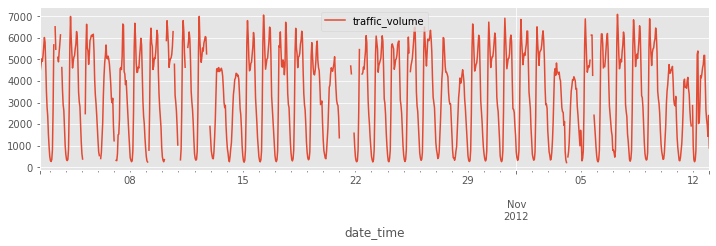

In [9]:
class MetroInterstateTraffic(RegressionForecastData):
    """
    See: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume
    """
    
    columns_target = ['traffic_volume']
    columns_forecast = ['holiday', 'month', 'day', 'week', 'hour',
       'minute', 'dayofweek']
    
    def download(self):
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'
        
        # download if needed
        filename = '00492_Metro_Interstate_Traffic_Volume.csv.gz'
        local_path = self.datasets_root/filename
        if not local_path.exists():
            download_url(url, self.datasets_root, filename)
        df = (pd.read_csv(local_path, index_col='date_time', parse_dates=['date_time'])
              .dropna(subset=self.columns_target)
              .resample('1H').first()
             )
        
        # Make holiday a bool
        df['holiday'] = ~df['holiday'].isna()
        df['weather_main'] = df['weather_main'].fillna('none')
        df['weather_description'] = df['weather_description'].fillna('none')
        
        # Add time features 
        time = df.index.to_series()
        df["month"] = time.dt.month
        df['day'] = time.dt.day
        df['week'] = time.dt.isocalendar().week
        df['hour'] = time.dt.hour
        df['minute'] = time.dt.minute
        df['dayofweek'] = time.dt.dayofweek
        
        return df
    

dataset = MetroInterstateTraffic(datasets_root)
dataset.df[dataset.columns_target].head(1000).plot()
print(dataset)
dataset.df

<AppliancesEnergyPrediction (19735, 34)>


,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,Tdewpoint,rv1,rv2,log_Appliances,month,day,week,hour,minute,dayofweek
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,...,5.300000,13.275433,13.275433,4.094345,1,11,2,17,0,0
2016-01-11 17:10:00,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,...,5.200000,18.606195,18.606195,4.094345,1,11,2,17,10,0
2016-01-11 17:20:00,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,...,5.100000,28.642668,28.642668,3.912023,1,11,2,17,20,0
2016-01-11 17:30:00,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,...,5.000000,45.410389,45.410389,3.912023,1,11,2,17,30,0
2016-01-11 17:40:00,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,...,4.900000,10.084097,10.084097,4.094345,1,11,2,17,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,...,13.333333,43.096812,43.096812,4.605170,5,27,21,17,20,4
2016-05-27 17:30:00,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,...,13.300000,49.282940,49.282940,4.499810,5,27,21,17,30,4
2016-05-27 17:40:00,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,...,13.266667,29.199117,29.199117,5.598422,5,27,21,17,40,4


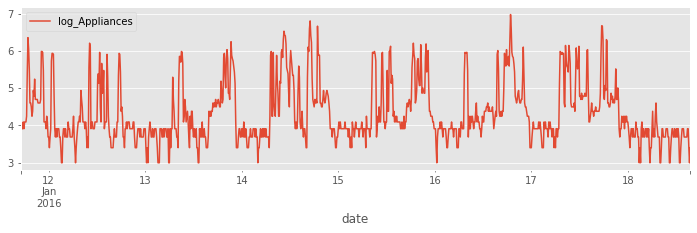

In [10]:
class AppliancesEnergyPrediction(RegressionForecastData):
    """
    See: https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
    """
    
    columns_target = ['log_Appliances']
    columns_forecast = ['month', 'day', 'week', 'hour',
       'minute', 'dayofweek']
    
    def download(self):
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv'
        
        # download if needed
        filename = '00374_AppliancesEnergyPrediction.csv'
        local_path = self.datasets_root/filename
        if not local_path.exists():
            download_url(url, self.datasets_root, filename)
        df = pd.read_csv(local_path, index_col='date', parse_dates=['date'])
        
        # log target
        df['log_Appliances'] = np.log(df['Appliances'] + 1e-5)
        df = df.drop(columns=['Appliances'])
        df = df.dropna(subset=self.columns_target).resample('10T').first()
        
        # Add time features 
        time = df.index.to_series()
        df["month"] = time.dt.month
        df['day'] = time.dt.day
        df['week'] = time.dt.isocalendar().week
        df['hour'] = time.dt.hour
        df['minute'] = time.dt.minute
        df['dayofweek'] = time.dt.dayofweek
        
        return df
dataset = AppliancesEnergyPrediction(datasets_root)
print(dataset)
dataset.df[dataset.columns_target].head(1000).plot()
dataset.df

<BejingPM25 (43800, 14)>


,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,log_pm2.5,month,day,week,hour,minute,dayofweek
2010-01-02 00:00:00+08:00,-16.0,-4.0,1020.0,SE,1.79,0.0,0.0,4.859812,1,2,53,0,0,5
2010-01-02 01:00:00+08:00,-15.0,-4.0,1020.0,SE,2.68,0.0,0.0,4.997212,1,2,53,1,0,5
2010-01-02 02:00:00+08:00,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0,5.068904,1,2,53,2,0,5
2010-01-02 03:00:00+08:00,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0,5.198497,1,2,53,3,0,5
2010-01-02 04:00:00+08:00,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0,4.927254,1,2,53,4,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00+08:00,-23.0,-2.0,1034.0,NW,231.97,0.0,0.0,2.079443,12,31,1,19,0,2
2014-12-31 20:00:00+08:00,-22.0,-3.0,1034.0,NW,237.78,0.0,0.0,2.302586,12,31,1,20,0,2
2014-12-31 21:00:00+08:00,-22.0,-3.0,1034.0,NW,242.70,0.0,0.0,2.302586,12,31,1,21,0,2
2014-12-31 22:00:00+08:00,-22.0,-4.0,1034.0,NW,246.72,0.0,0.0,2.079443,12,31,1,22,0,2


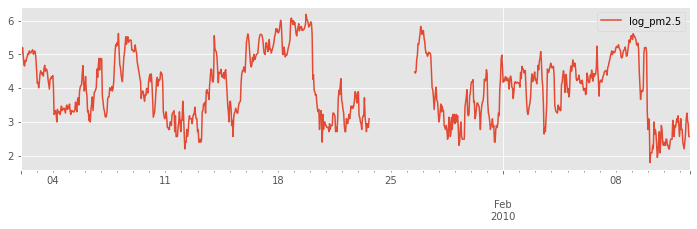

In [11]:
class BejingPM25(RegressionForecastData):
    """
    See: http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data
    """
    
    columns_target = ['log_pm2.5']
    columns_forecast = ['month', 'day', 'week', 'hour',
       'minute', 'dayofweek']
    
    def download(self):
        url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
        
        # download if needed
        filename = '00381_BejingPM25.csv'
        local_path = self.datasets_root/filename
        if not local_path.exists():
            download_url(url, self.datasets_root, filename)
        df = pd.read_csv(local_path)
        df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour']]).dt.tz_localize('Asia/Shanghai')
        df = df.drop(columns=['year', 'month', 'day', 'hour', 'No'])
        
        # log target
        df['log_pm2.5'] = np.log(df['pm2.5'] + 1e-5)
        df = df.drop(columns=['pm2.5'])
        
        df.dropna(subset=self.columns_target, inplace=True)
        df = df.resample('1H').first()
        
        df['cbwd'] = df['cbwd'].fillna('none')
        
        
        
        # Add time features 
        time = df.index.to_series()
        df["month"] = time.dt.month
        df['day'] = time.dt.day
        df['week'] = time.dt.isocalendar().week
        df['hour'] = time.dt.hour
        df['minute'] = time.dt.minute
        df['dayofweek'] = time.dt.dayofweek
        
#         df['log_pm2.5'] = np.log(df['pm2.5']+1e-5)
        
        return df
dataset = BejingPM25(datasets_root)
print(dataset)
dataset.df[dataset.columns_target].head(1000).plot()
dataset.df

In [12]:
import uptide
import xarray as xr

# https://en.wikipedia.org/wiki/Theory_of_tides#Harmonic_analysis
default_tidal_constituents = [
    'M2',
    'S2',
    'N2',
    'K2',  # Semi-diurnal
    'K1',
    'O1',
    'P1',
    'Q1',  # Diurnal
    'M4',
    'M6',
    'S4',
    'MK3',  # Short period
    'MM',
    'SSA',
    'SA'  # Long period
]


def generate_tidal_periods(t: pd.Series,
                           constituents: list = default_tidal_constituents):
    tide = uptide.Tides(constituents)
    t0 = t[0]
    td = t - t0
    td = td.dt.total_seconds().to_numpy().astype(int)
    tide.set_initial_time(t0)

    # calc tides
    amplitudes = np.ones_like(td)
    phases = np.zeros_like(td)
    eta = {}
    for name, f, amplitude, omega, phase, phi, u in zip(
            tide.constituents, tide.f, amplitudes, tide.omega, phases,
            tide.phi, tide.u):
        eta[name] = f * amplitude * np.cos(omega * td - phase + phi + u)
    df_eta = pd.DataFrame(eta, index=t)
    return df_eta


# 'ANMN Two Rocks, WA, 204m mooring, Jul2009 - Dec2009. Preprocessed with DepthPP.'


def get_current_timeseries(
        cache_folder=Path("../data/raw/IMOS_ANMN/"),
        outfile=Path(
            '../data/processed/currents/MOS_ANMN-WA_AETVZ_WATR20_FV01_WATR20-1909-Continental-194_currents.nc'
        )):
    """
    Download Current data from the IMOS and pre-process.
    """
    if not outfile.exists():

        files = [
            "IMOS_ANMN-WA_AETVZ_20090715T080000Z_WATR20_FV01_WATR20-0907-Continental-194_END-20090716T181317Z_C-20191122T052830Z.nc",
            "IMOS_ANMN-WA_AETVZ_20100409T080000Z_WATR20_FV01_WATR20-1004-Continental-194_END-20100430T084500Z_C-20191122T053845Z.nc",
            "IMOS_ANMN-WA_AETVZ_20101222T080000Z_WATR20_FV01_WATR20-1012-Continental-194_END-20110518T051500Z_C-20200916T020035Z.nc",
            "IMOS_ANMN-WA_AETVZ_20110608T080000Z_WATR20_FV01_WATR20-1106-Continental-194_END-20111122T035000Z_C-20200916T025619Z.nc",
            "IMOS_ANMN-WA_AETVZ_20111221T060300Z_WATR20_FV01_WATR20-1112-Continental-194_END-20120704T050500Z_C-20200916T043212Z.nc",
            "IMOS_ANMN-WA_AETVZ_20120726T044000Z_WATR20_FV01_WATR20-1207-Continental-194_END-20130204T044000Z_C-20200916T032027Z.nc",
            "IMOS_ANMN-WA_AETVZ_20130221T080000Z_WATR20_FV01_WATR20-1302-Continental-194_END-20131003T035000Z_C-20180529T020609Z.nc",
            "IMOS_ANMN-WA_AETVZ_20131111T080000Z_WATR20_FV01_WATR20-1311-Continental-194_END-20140519T035000Z_C-20200114T033335Z.nc",
            "IMOS_ANMN-WA_AETVZ_20140710T080000Z_WATR20_FV01_WATR20-1407-Continental-194_END-20150121T021500Z_C-20180529T055902Z.nc",
            "IMOS_ANMN-WA_AETVZ_20150213T080000Z_WATR20_FV01_WATR20-1502-Continental-194_END-20150424T134002Z_C-20200114T035347Z.nc",
            "IMOS_ANMN-WA_AETVZ_20150914T080000Z_WATR20_FV01_WATR20-1509-Continental-194_END-20160331T043000Z_C-20180601T013623Z.nc",
            "IMOS_ANMN-WA_AETVZ_20160427T080000Z_WATR20_FV01_WATR20-1604-Continental-194_END-20160531T021800Z_C-20180531T071709Z.nc",
            #     "IMOS_ANMN-WA_AETVZ_20170512T080000Z_WATR20_FV01_WATR20-1705-Continental-194_END-20170717T014558Z_C-20190805T004647Z.nc",
            "IMOS_ANMN-WA_AETVZ_20171204T080000Z_WATR20_FV01_WATR20-1712-Continental-194_END-20180618T030000Z_C-20180620T233149Z.nc",
            "IMOS_ANMN-WA_AETVZ_20180802T080000Z_WATR20_FV01_WATR20-1807-Continental-194_END-20190225T054500Z_C-20190227T001343Z.nc",
            "IMOS_ANMN-WA_AETVZ_20190307T080000Z_WATR20_FV01_WATR20-1903-Continental-194_END-20190911T003144Z_C-20200114T045053Z.nc",
            "IMOS_ANMN-WA_AETVZ_20190926T080000Z_WATR20_FV01_WATR20-1909-Continental-194_END-20200326T030000Z_C-20200420T064334Z.nc",
        ]
        base = "http://thredds.aodn.org.au/thredds/fileServer/IMOS/ANMN/WA/WATR20/Velocity/"

        # Download files
        [download_url(base + f, cache_folder) for f in files]

        # load and merge
        xds = [xr.open_dataset(cache_folder / f) for f in files]
        vars = [
            'VCUR', 'UCUR', 'WCUR', 'TEMP', 'PRES_REL', 'DEPTH', 'ROLL',
            'PITCH'
        ]
        xds2 = [x[vars].isel(HEIGHT_ABOVE_SENSOR=18) for x in xds]
        xd = xr.concat(xds2, dim='TIME')
        xd = xd.where(xd.DEPTH > 150)  # remove outliers

        xd['TIME'] = xd['TIME'].dt.round('10T')
        xd = xd.dropna(dim='TIME', subset=['VCUR', 'UCUR', 'WCUR'])

        # Generate tidal freqs
        t = xd.TIME.to_series()
        df_eta = generate_tidal_periods(t)

        # Add tidal freqs
        xd = xd.merge(df_eta)

        # Cache to nc
        xd.to_netcdf(outfile)
        print(
            f'wrote "{outfile}" with size {outfile.stat().st_size*1e-6:2.2f} MB'
        )
    return outfile


class IMOSCurrentsVel(RegressionForecastData):
    """
    
    Current Speed at ANMN Two Rocks, WA, 204m mooring
    
    see:
    - http://thredds.aodn.org.au/thredds/fileServer/IMOS/ANMN/WA/WATR20/Velocity/
    from https://catalogue-imos.aodn.org.au/geonetwork/srv/api/records/ae86e2f5-eaaf-459e-a405-e654d85adb9c
    and http://thredds.aodn.org.au/thredds/catalog/IMOS/ANMN/WA/WATR20/Velocity/catalog.html
    And https://en.wikipedia.org/wiki/Theory_of_tides
    """

    columns_target = ['SPD']
    columns_forecast = [
        'M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1', 'M4', 'M6', 'S4',
        'MK3', 'MM', 'SSA', 'SA'
    ]

    def download(self):
        outfile = self.datasets_root / 'MOS_ANMN-WA_AETVZ_WATR20_FV01_WATR20-1909-Continental-194_currents.nc'
        get_current_timeseries(outfile=outfile)

        # made in previous notebook
        xd = xarray.load_dataset(outfile)
        df = xd.to_dataframe().drop(
            columns=['HEIGHT_ABOVE_SENSOR', 'NOMINAL_DEPTH'])
        df['SPD'] = np.sqrt(df.VCUR**2 + df.UCUR**2)
        df.dropna(subset=self.columns_target, inplace=True)
        df = df.resample('30T').first()

        return df


dataset = IMOSCurrentsVel(datasets_root)
dataset.df[dataset.columns_target].dropna().head(1000).plot()
dataset.df

Using downloaded and verified file: ../data/raw/IMOS_ANMN/IMOS_ANMN-WA_AETVZ_20090715T080000Z_WATR20_FV01_WATR20-0907-Continental-194_END-20090716T181317Z_C-20191122T052830Z.nc
Using downloaded and verified file: ../data/raw/IMOS_ANMN/IMOS_ANMN-WA_AETVZ_20100409T080000Z_WATR20_FV01_WATR20-1004-Continental-194_END-20100430T084500Z_C-20191122T053845Z.nc
Using downloaded and verified file: ../data/raw/IMOS_ANMN/IMOS_ANMN-WA_AETVZ_20101222T080000Z_WATR20_FV01_WATR20-1012-Continental-194_END-20110518T051500Z_C-20200916T020035Z.nc
Using downloaded and verified file: ../data/raw/IMOS_ANMN/IMOS_ANMN-WA_AETVZ_20110608T080000Z_WATR20_FV01_WATR20-1106-Continental-194_END-20111122T035000Z_C-20200916T025619Z.nc
Using downloaded and verified file: ../data/raw/IMOS_ANMN/IMOS_ANMN-WA_AETVZ_20111221T060300Z_WATR20_FV01_WATR20-1112-Continental-194_END-20120704T050500Z_C-20200916T043212Z.nc
Using downloaded and verified file: ../data/raw/IMOS_ANMN/IMOS_ANMN-WA_AETVZ_20120726T044000Z_WATR20_FV01_WATR20-12

NameError: name 'xarray' is not defined